# GetPeople - Find Your Lost People
Find your lost people with us!

# Import Libraries and Packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cv2
import tensorflow as tf
import collections
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Dataset

## Utility Functions

In [ ]:
## This function for making pairs  
## (both positive and negative pairs)
def generate_pairs(images, labels):
  # Generate label and index
  label_unique = np.unique(labels)                  # make a dictionary like this :
  label_indices = collections.defaultdict(list)     # label_indices = {
  i = 0                                             # 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  for idx, label in enumerate(labels):              # 1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    if label == i:                                  # ...
      label_indices[label].append(idx)              # }
    else:
      i += 1

  # Generate image and labels pairs
  pair_images = []
  pair_labels = []
  for idx, image in enumerate(images):
    # positive pairs
    indices = label_indices.get(labels[idx])     # indices = [11, 12, 13, 14, 15, 16, 17, 18, 19]
    positive = images[np.random.choice(indices)] # image = take random image from index above
    pair_images.append((image, positive))        # make a positive pairs
    pair_labels.append(1)                        # (+) pairs labeled with 1

    # negative pairs
    indices = np.where(labels != labels[idx])         # neg_indices = other indices from indices above 
    negative = images[np.random.choice(indices[0])]   # neg_indices[0] -> take array from list
    pair_images.append((image, negative))             # make a negative pairs
    pair_labels.append(0)                             # (-) pairs labeled with 0
      
  return np.array(pair_images), np.array(pair_labels)

## Prepare Data

In [ ]:
# Get the GDrive paths
# https://drive.google.com/file/d/1RWfKbQB-OMD8bIeyM0GnqovCA3VOWZgw/view?usp=sharing
!gdown 'https://drive.google.com/uc?id=1RWfKbQB-OMD8bIeyM0GnqovCA3VOWZgw'

Downloading...
From: https://drive.google.com/uc?id=1RWfKbQB-OMD8bIeyM0GnqovCA3VOWZgw
To: /content/olivetti.zip
100% 1.90M/1.90M [00:00<00:00, 198MB/s]


In [ ]:
# Unzip the file
!unzip /content/olivetti.zip

Archive:  /content/olivetti.zip
  inflating: olivetti_faces.npy      
  inflating: olivetti_faces_target.npy  


In [ ]:
# Get the data directory paths
faces = '/content/olivetti_faces.npy'
faces_targets = '/content/olivetti_faces_target.npy'

In [ ]:
# Load the images and labels
face_images = np.load(faces)
face_labels = np.load(faces_targets)

In [ ]:
target_shape = face_images[0].shape

In [ ]:
images_dataset, labels_dataset = generate_pairs(face_images, face_labels)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

## Visualize

In [ ]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    plt.title(title)
    axs = fig.subplots(n, 2)
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])

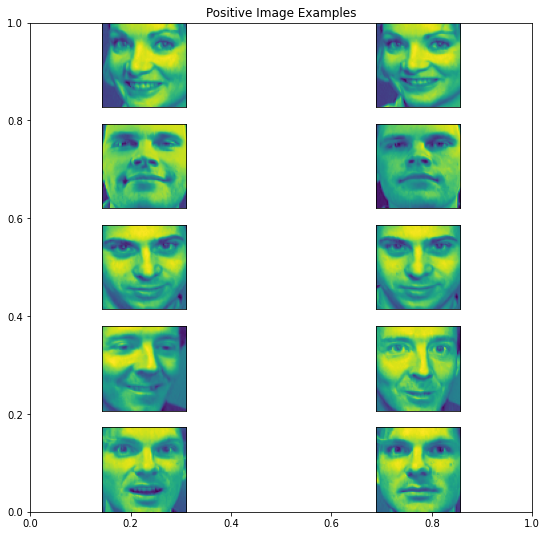

In [ ]:
# Visualize Positive Images
n = 5
indices = np.where(labels_dataset == 1)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Positive Image Examples")

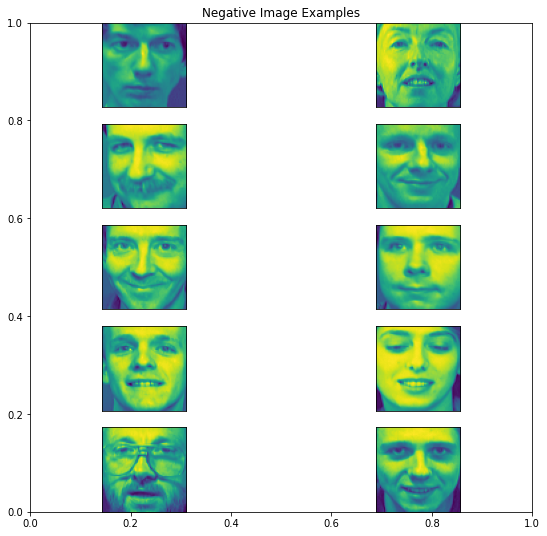

In [ ]:
# Visualize Negative Images
n = 5
indices = np.where(labels_dataset == 0)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Negative Image Examples")

# Network Architecture

## Embedding Layer

In [ ]:
inputs = layers.Input((64, 64, 1))

x = layers.Conv2D(64, (10, 10), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (7, 7), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (4, 4), padding="same", activation="relu")(x)
fcOutput = layers.Flatten()(x)
fcOutput = layers.Dense(4096, activation = "relu")(fcOutput)
outputs = layers.Dense(1024, activation = "sigmoid")(fcOutput)

embedding = Model(inputs, outputs, name = "Embedding")

## Siamese Network

In [ ]:
import tensorflow.keras.backend as K

In [ ]:
# Define the Contrastive Loss
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss

In [ ]:
# Distance Layer
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance
    between the embeddings
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [ ]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (1,))
compare_input = layers.Input(name="compare", shape=target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),
)

outputs = layers.Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)

# Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
checkpoints = ModelCheckpoint('Model' + '{accuracy:.2f}acc.h5', verbose=1) # Create Keras SavedModel as checkpoints

In [ ]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :]], labels_dataset,
                            epochs=150, validation_split = 0.2, batch_size = 64)

Epoch 1/150
10/10 [==============================] - 15s 213ms/step - loss: 0.6712 - accuracy: 0.5078 - val_loss: 0.6276 - val_accuracy: 0.5188
Epoch 2/150
10/10 [==============================] - 1s 120ms/step - loss: 0.6411 - accuracy: 0.5078 - val_loss: 0.6150 - val_accuracy: 0.5188
Epoch 3/150
10/10 [==============================] - 1s 127ms/step - loss: 0.6379 - accuracy: 0.5078 - val_loss: 0.6199 - val_accuracy: 0.5250
Epoch 4/150
10/10 [==============================] - 1s 126ms/step - loss: 0.6215 - accuracy: 0.5078 - val_loss: 0.6176 - val_accuracy: 0.5312
Epoch 5/150
10/10 [==============================] - 1s 119ms/step - loss: 0.6177 - accuracy: 0.5125 - val_loss: 0.5910 - val_accuracy: 0.5312
Epoch 6/150
10/10 [==============================] - 1s 119ms/step - loss: 0.6104 - accuracy: 0.5141 - val_loss: 0.6007 - val_accuracy: 0.6000
Epoch 7/150
10/10 [==============================] - 1s 120ms/step - loss: 0.6051 - accuracy: 0.5219 - val_loss: 0.6035 - val_accuracy: 0.575

In [ ]:
siamese_model.save('/content/')

INFO:tensorflow:Assets written to: /content/assets


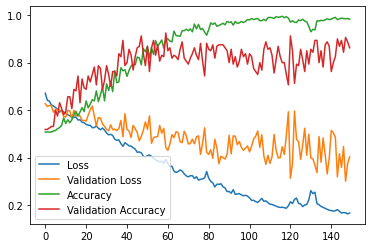

In [ ]:
# Training Plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])

# Testing

In [ ]:
def test_visualize(images, n = 5):
    """ Visualize a few images """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9)) 
    axs = fig.subplots(1, n)
    for i in range(n):
        show(axs[i], images[i])

## Test 1

In [ ]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

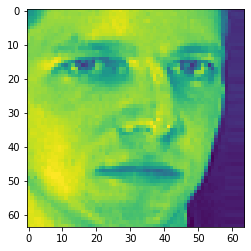

In [ ]:
plt.imshow(test_image)

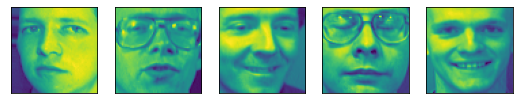

In [ ]:
test_visualize(compare_images)

In [ ]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))
    
image_pairs = np.array(image_pairs)

In [ ]:
image_pairs.shape

(5, 2, 64, 64)

In [ ]:
image_pairs[:,0,:]

array([[[0.45454547, 0.47107437, 0.5123967 , ..., 0.19008264,
         0.18595041, 0.18595041],
        [0.446281  , 0.48347107, 0.5206612 , ..., 0.21487603,
         0.2107438 , 0.2107438 ],
        [0.49586776, 0.5165289 , 0.53305787, ..., 0.20247933,
         0.20661157, 0.20661157],
        ...,
        [0.77272725, 0.78099173, 0.7933884 , ..., 0.1446281 ,
         0.1446281 , 0.1446281 ],
        [0.77272725, 0.7768595 , 0.7892562 , ..., 0.13636364,
         0.13636364, 0.13636364],
        [0.7644628 , 0.7892562 , 0.78099173, ..., 0.15289256,
         0.15289256, 0.15289256]],

       [[0.45454547, 0.47107437, 0.5123967 , ..., 0.19008264,
         0.18595041, 0.18595041],
        [0.446281  , 0.48347107, 0.5206612 , ..., 0.21487603,
         0.2107438 , 0.2107438 ],
        [0.49586776, 0.5165289 , 0.53305787, ..., 0.20247933,
         0.20661157, 0.20661157],
        ...,
        [0.77272725, 0.78099173, 0.7933884 , ..., 0.1446281 ,
         0.1446281 , 0.1446281 ],
        [0.7

In [ ]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

In [ ]:
print(score)

[[0.5737109 ]
 [0.37184292]
 [0.00372333]
 [0.00360865]
 [0.0033654 ]]


## Test 2

In [ ]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(20, 30), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

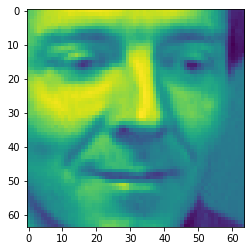

In [ ]:
plt.imshow(test_image)

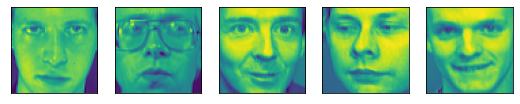

In [ ]:
test_visualize(compare_images)

In [ ]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))
    
image_pairs = np.array(image_pairs)

In [ ]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

In [ ]:
print(score)

[[0.00448989]
 [0.00633015]
 [0.28666624]
 [0.32355672]
 [0.10705248]]
